In [104]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score,fbeta_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [ ]:
#os.chdir(r'D:\use case\Loan Default Prediction\data')

In [105]:
df = pd.read_csv('processed_data.csv')

In [3]:
df.head(10)

,Client_Income_category,Credit_Amount_category,Credit_to_Income_Category,Loan_Annuity_category,Client_Family_Members_Category,Car_Owned,Bike_Owned,Active_Loan,Accompany_Client,Client_Income_Type,...,Cleint_City_Rating,Application_Process_Day,Application_Hour_Category,Type_Organization_Grouped,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change_category,Credit_Bureau_Category,Default
0,income_band2,credit_band6,Upto_10_times,upto_6_percent,2_members,0,0,1,Alone,Commercial,...,2.0,6.0,upto_18_hours,Self-employed,0.478787,0.511180,1,same_year,no_search,0
1,income_band5,credit_band1,Upto_2_times,more_than_8_percent,2_members,1,0,1,Alone,Service,...,2.0,3.0,upto_12_hours,Public Sector,0.215068,0.511180,0,same_year,no_search,0
2,income_band4,credit_band5,Upto_4_times,upto_6_percent,2_members,0,0,1,Alone,Service,...,2.0,4.0,upto_12_hours,Self-employed,0.552795,0.329655,1,same_year,no_search,0
3,income_band4,credit_band5,Upto_4_times,upto_6_percent,2_members,0,0,1,Alone,Retired,...,3.0,2.0,upto_18_hours,Self-employed,0.135182,0.631355,0,four_year,more_than_two_search,0
4,income_band5,credit_band6,Upto_4_times,upto_4_percent,more_than_3_members,1,0,1,Alone,Commercial,...,1.0,3.0,upto_12_hours,Business,0.301182,0.355639,1,one_year,one_search,0
5,income_band3,credit_band1,Upto_2_times,upto_6_percent,2_members,0,1,1,Alone,Service,...,2.0,2.0,upto_12_hours,Other,0.697928,0.420611,1,two_year,no_search,0
6,income_band4,credit_band6,Upto_10_times,upto_4_percent,upto_1_member,1,1,0,Alone,Retired,...,2.0,3.0,upto_18_hours,Self-employed,0.602545,0.511892,1,same_year,more_than_two_search,0
7,income_band3,credit_band6,Upto_5_times,upto_6_percent,2_members,0,0,1,Alone,Retired,...,2.0,4.0,upto_18_hours,Self-employed,0.657508,0.549597,0,four_year,more_than_two_search,0
8,income_band3,credit_band4,Upto_4_times,upto_4_percent,3_members,1,1,0,Relative,Commercial,...,2.0,4.0,upto_18_hours,Self-employed,0.637594,0.553165,1,four_year,no_search,0
9,income_band3,credit_band1,Upto_2_times,upto_8_percent,upto_1_member,0,0,0,Alone,Retired,...,2.0,2.0,upto_12_hours,Self-employed,0.063343,0.080650,0,one_year,more_than_two_search,0


In [ ]:
df.Default.dtype

In [106]:
# Step 1: Convert all categorical columns to object, excluding 'Score_Source_2', 'Score_Source_3'
categorical_columns = [col for col in df.columns if col not in ['Score_Source_2', 'Score_Source_3']]
df[categorical_columns] = df[categorical_columns].astype('object')


In [107]:
# If it's numeric but string-like:
df['Default'] = df['Default'].astype(int)

In [108]:
# Step 2: Split into features and target
X = df.drop('Default', axis=1)
y = df['Default']

In [109]:
# Step 3: Define preprocessing pipelines
numeric_features = ['Score_Source_2', 'Score_Source_3']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [110]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [111]:
# Step 4: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [112]:
X_train.shape
print(X_test.shape)

(36557, 29)


In [113]:
import pickle
pickle.dump(preprocessor, open('data_scaling_new.pkl', 'wb'))

In [114]:
# Step 5: Fit preprocessing pipeline to training data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [11]:
# Step 6: Train logistic regression on preprocessed data
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_prepared, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [12]:
# Step 7: Make predictions
y_pred = model.predict(X_test_prepared)
y_prob = model.predict_proba(X_test_prepared)[:, 1]  # for ROC-AUC

In [13]:
# Step 8: Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     33619
           1       0.57      0.01      0.01      2938

    accuracy                           0.92     36557
   macro avg       0.75      0.50      0.48     36557
weighted avg       0.89      0.92      0.88     36557

Accuracy: 0.9197417731214268
Precision: 0.5714285714285714
Recall: 0.005445881552076242
F1 Score: 0.01078894133513149
ROC AUC Score: 0.7278921480893764


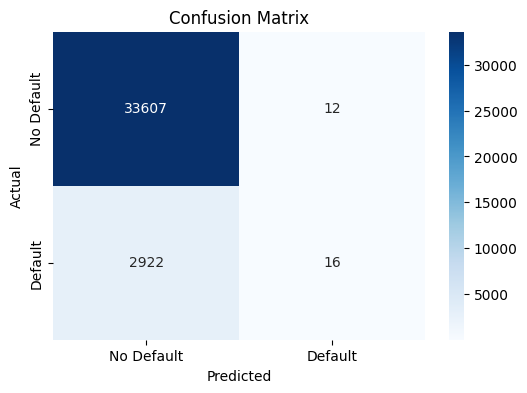

In [14]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
xgb1 = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)

In [23]:
xgb1.fit(X_train_prepared,y_train)

C:\Users\biswa\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [02:17:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [24]:
 # Predict
y_pred = model.predict(X_test_prepared)
y_prob = model.predict_proba(X_test_prepared)[:, 1]
  
results = []
    # Evaluate
results.append({
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

# Create a DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)

In [67]:
results

[{'Model': 'XGBoost',
  'Accuracy': 0.9197144185792051,
  'Precision': 0.5555555555555556,
  'Recall': 0.0051055139550714775,
  'F1 Score': 0.01011804384485666,
  'ROC AUC': 0.7278473482257057}]

In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Store results
results = []

# Loop through models
for name, model in models.items():
    # For Naive Bayes: it doesn't work with sparse matrix (from OneHotEncoder), convert to dense
    X_train_mod = X_train_prepared.toarray() if name == 'Naive Bayes' else X_train_prepared
    X_test_mod = X_test_prepared.toarray() if name == 'Naive Bayes' else X_test_prepared
    
    # Train
    model.fit(X_train_mod, y_train)
    
    # Predict
    y_pred = model.predict(X_test_mod)
    y_prob = model.predict_proba(X_test_mod)[:, 1]
    
    # Evaluate
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

# Create a DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)

In [27]:
# Step 1: Compute scale_pos_weight for imbalance
# Formula: count(negative class) / count(positive class)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 11.35


In [28]:
# Step 2: Define XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

In [38]:
# Step 3: Hyperparameter grid (basic but effective)
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}


In [39]:
# Step 4: Use recall as scoring metric
recall_scorer = make_scorer(recall_score)

In [108]:
# Step 4: Define F-beta scorer with beta = 3
fbeta_scorer = make_scorer(fbeta_score, beta=4)

In [52]:
# Step 5: Cross-validation with GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=fbeta_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [53]:
# Step 6: Fit model
grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\biswa\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.01],
                         'max_depth': [3], 'n_estimators': [100],
                         'subsample': [0.8]},
             scoring=make_scorer(fbeta_score, beta=0.8), verbose=1)

In [42]:
# Step 7: Best model and recall score
print("Best Parameters:\n", grid_search.best_params_)
print("Best Recall Score on CV:", grid_search.best_score_)




Best Parameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Recall Score on CV: 0.6095297876598995


In [68]:
# Step 8: Predict on test set using best estimator

y_pred_test = grid_search.best_estimator_.predict(X_test_prepared)

# Step 9: Evaluate on test data
print("Test Recall Score:", recall_score(y_test, y_pred_test))

Test Recall Score: 0.6010891763104153


In [69]:
results.append({
        'Model': 'grid_search_XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1 Score': f1_score(y_test, y_pred_test),
        'ROC AUC': roc_auc_score(y_test, y_pred_test)
    })

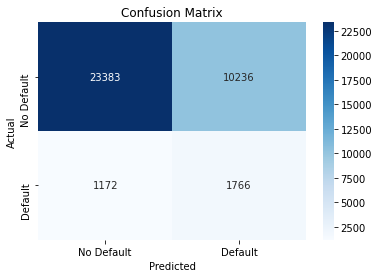

In [55]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [76]:
# Expanded hyperparameter grid for random search
param_distributions = {
    'n_estimators': [100, 200, 300,400,500],
    'max_depth': [3, 5, 7,9],
    'learning_rate': [0.01, 0.05, 0.1,0.3],
    'subsample': [0.2,0,4,0.6, 0.8],
    'colsample_bytree': [0.4,0.6, 0.8]
}

In [77]:
# RandomizedSearchCV with more parameter combinations
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    scoring=fbeta_scorer,
    cv=5,
    n_iter=50,  # You can adjust this depending on how many random combos you want to try
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [78]:
# Step 6: Fit model
random_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\biswa\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\biswa\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\biswa\anaconda3\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\biswa\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
  File "C:\Users\biswa\anaconda3\lib\site-packages\xgboost\core.py", line 72

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.6, 0.8],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.2, 0, 4, 0.6, 0.8]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=2.2),
                   verbose=2)

In [79]:
# Step 8: Predict on test set using best estimator

y_pred_test_random = random_search.best_estimator_.predict(X_test_prepared)

# Step 9: Evaluate on test data
print("Test Recall Score:", recall_score(y_test, y_pred_test_random))

Test Recall Score: 0.6507828454731109


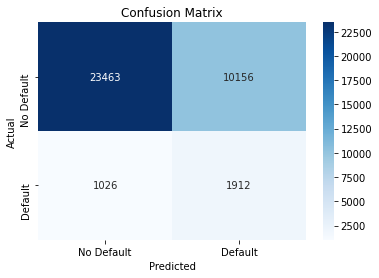

In [80]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test_random)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [81]:
results.append({
        'Model': 'random_search_XGBoost_modified',
        'Accuracy': accuracy_score(y_test, y_pred_test_random),
        'Precision': precision_score(y_test, y_pred_test_random),
        'Recall': recall_score(y_test, y_pred_test_random),
        'F1 Score': f1_score(y_test, y_pred_test_random),
        'ROC AUC': roc_auc_score(y_test, y_pred_test_random)
    })

In [82]:
# Create a DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)

In [83]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.919714,0.555556,0.005106,0.010118,0.727847
3,random_search_XGBoost_modified,0.694122,0.158436,0.650783,0.254831,0.674346
2,random_search_XGBoost,0.791640,0.198712,0.525187,0.288330,0.670057
1,grid_search_XGBoost,0.687939,0.147142,0.601089,0.236412,0.648309


In [74]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [109]:
random_search.best_params_

{'subsample': 0.6,
 'n_estimators': 500,
 'max_depth': 3,
 'learning_rate': 0.05,
 'colsample_bytree': 0.6}

In [110]:
param_grid = {
    'n_estimators': [500,450],
    'max_depth': [3, 5,7],
    'learning_rate': [0.05],
    'subsample': [0.6],
    'colsample_bytree': [0.6],
    'reg_alpha': [ 0.1, 0.2,0.3],          # L1 regularization
    'reg_lambda': [1, 1.5, 2]        # L2 regularization
}

In [115]:
# Step 5: Cross-validation with GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=fbeta_scorer,
    cv=3,
    n_jobs=1,
    verbose=3
)

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [118]:
grid_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.6;, score=0.543 total time=   1.6s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.6;, score=0.553 total time=   1.6s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.6;, score=0.540 total time=   1.6s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6;, score=0.548 total time=   1.7s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6;, score=0.554 total time=   1.8s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1.5, subsamp

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.6], 'learning_rate': [0.05],
                         'max_depth': [3, 5, 7], 'n_estimators': [500, 450],
                         'reg_alpha': [0.1, 0.2, 0.3],
                         'reg_lambda': [1, 1.5, 2], 'subsample': [0.6]},
             scoring=make_scorer(fbeta_score, beta=4), verbose=3)

In [119]:
grid_search.best_score_

0.5480264018144329

In [128]:
grid_search.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 450,
 'reg_alpha': 0.2,
 'reg_lambda': 2,
 'subsample': 0.6}

In [120]:
# Step 8: Predict on test set using best estimator

y_pred_test_grid = grid_search.best_estimator_.predict(X_test_prepared)

# Step 9: Evaluate on test data
print("Test Recall Score:", recall_score(y_test, y_pred_test_grid))

Test Recall Score: 0.6531654186521443


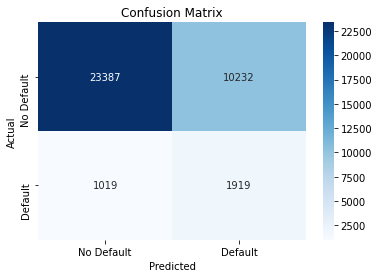

In [121]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test_grid)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [125]:
results.append({
        'Model': 'random_search_XGBoost_modified1',
        'Accuracy': accuracy_score(y_test, y_pred_test_grid),
        'Precision': precision_score(y_test, y_pred_test_grid),
        'Recall': recall_score(y_test, y_pred_test_grid),
        'F1 Score': f1_score(y_test, y_pred_test_grid),
        'ROC AUC': roc_auc_score(y_test, y_pred_test_grid)
    })

In [126]:
# Create a DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)

In [127]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.919714,0.555556,0.005106,0.010118,0.727847
4,random_search_XGBoost_modified,0.692234,0.157929,0.653165,0.254357,0.674407
5,random_search_XGBoost_modified1,0.692234,0.157929,0.653165,0.254357,0.674407
3,random_search_XGBoost_modified,0.694122,0.158436,0.650783,0.254831,0.674346
2,random_search_XGBoost,0.791640,0.198712,0.525187,0.288330,0.670057
1,grid_search_XGBoost,0.687939,0.147142,0.601089,0.236412,0.648309


In [134]:
pip install --upgrade numpy


  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0



ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\biswa\\anaconda3\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [135]:
pip install --upgrade catboost


Requirement already up-to-date: catboost in c:\users\biswa\anaconda3\lib\site-packages (1.2.8)
Note: you may need to restart the kernel to use updated packages.


In [48]:
# Step 4: Define F-beta scorer with beta = 3
fbeta_scorer = make_scorer(fbeta_score, beta=0.7)

In [63]:
from catboost import CatBoostClassifier


# Define the CatBoostClassifier
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    auto_class_weights='Balanced'  # Automatically handles class imbalance
)

# Define the hyperparameter distributions
param_distributions = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1.0],
    'border_count': [32, 64, 128]
}
#{'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 
 #'depth': 4, 'border_count': 32, 'bagging_temperature': 0.5}
# param_distributions = {
#     'depth': [4],
#     'learning_rate': [0.1],
#     'iterations': [ 200],
#     'l2_leaf_reg': [3],
#     'bagging_temperature': [0.5],
#     'border_count': [32]
# }

# Randomized search
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    scoring='recall_micro',  # or 'f1_weighted'
    cv=5,
    n_iter=100,              # Try 20 random combinations
    n_jobs=1,
    verbose=3,
    random_state=42
)

# Fit to training data
random_search.fit(X_train_prepared, y_train)

# Output best results
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.691 total time=   4.0s
[CV 2/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.688 total time=   3.4s
[CV 3/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.690 total time=   3.1s
[CV 4/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.690 total time=   3.4s
[CV 5/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.698 total time=   3.2s
[CV 1/5] END bagging_temperature=1.0, border_count=32, depth=6, iterations=100, l2_leaf_reg=1, learning_rate=0.03;, score=0.682 total time=   2.5s
[CV 2/5] END bagging_temperature=1.0, border_count=32, depth

In [ ]:
# Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 10, 'border_count': 64, 'bagging_temperature': 0}
# Best Score: 0.8874195865435504

In [40]:
random_search.best_score_

np.float64(0.6368749247557641)

In [64]:
y_pred1 = random_search.best_estimator_.predict(X_test_prepared)
y_prob1 = random_search.best_estimator_.predict_proba(X_test_prepared)[:, 1]

In [58]:
y1 = pd.DataFrame(y_pred1)
y1.value_counts()

0
0    24312
1    12245
Name: count, dtype: int64

In [37]:
# Step 8: Predict on test set using best estimator

y_pred_test_grid = random_search.best_estimator_.predict(X_test_prepared)



In [47]:
cm

array([[23302, 10317],
       [ 1010,  1928]])

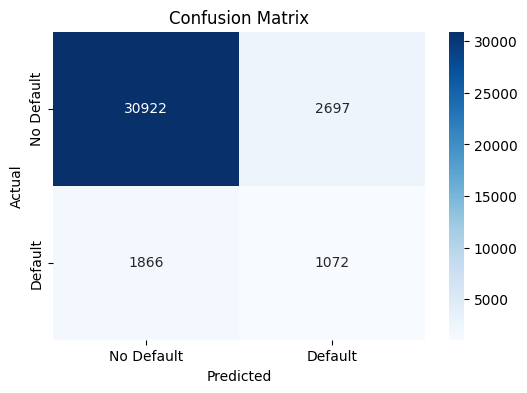

In [65]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
results=[]

In [66]:


results.append({
        'Model': 'CATBoost_modified_micro_recall',
        'Accuracy': accuracy_score(y_test, y_pred1),
        'Precision': precision_score(y_test, y_pred1),
        'Recall': recall_score(y_test, y_pred1),
        'F1 Score': f1_score(y_test, y_pred1),
        'ROC AUC': roc_auc_score(y_test, y_pred1),
        'Beta_value': 0
    })

In [67]:
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Beta_value
0,random_search_XGBoost_modified1,0.690155,0.157452,0.656229,0.253968,0.674674,4
1,random_search_CATBoost_modified,0.690155,0.157452,0.656229,0.253968,0.674674,5
2,CATBoost_modified_micro_recall,0.875181,0.284426,0.364874,0.319666,0.642326,0


In [68]:
from catboost import CatBoostClassifier


# Define the CatBoostClassifier
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    auto_class_weights='Balanced'  # Automatically handles class imbalance
)

# Define the hyperparameter distributions
param_distributions = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1.0],
    'border_count': [32, 64, 128]
}
#{'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 
 #'depth': 4, 'border_count': 32, 'bagging_temperature': 0.5}
# param_distributions = {
#     'depth': [4],
#     'learning_rate': [0.1],
#     'iterations': [ 200],
#     'l2_leaf_reg': [3],
#     'bagging_temperature': [0.5],
#     'border_count': [32]
# }

# Randomized search
random_search1 = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    scoring='recall',  # or 'f1_weighted'
    cv=5,
    n_iter=50,              # Try 20 random combinations
    n_jobs=1,
    verbose=3,
    random_state=42
)

# Fit to training data
random_search1.fit(X_train_prepared, y_train)

# Output best results
print("Best Parameters:", random_search1.best_params_)
print("Best Score:", random_search1.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.660 total time=   6.6s
[CV 2/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.665 total time=   4.9s
[CV 3/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.661 total time=   5.3s
[CV 4/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.651 total time=   5.3s
[CV 5/5] END bagging_temperature=0.5, border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1;, score=0.645 total time=   5.1s
[CV 1/5] END bagging_temperature=1.0, border_count=32, depth=6, iterations=100, l2_leaf_reg=1, learning_rate=0.03;, score=0.656 total time=   3.2s
[CV 2/5] END bagging_temperature=1.0, border_count=32, depth=

In [69]:
# Step 8: Predict on test set using best estimator

y_pred_test_recall = random_search1.best_estimator_.predict(X_test_prepared)



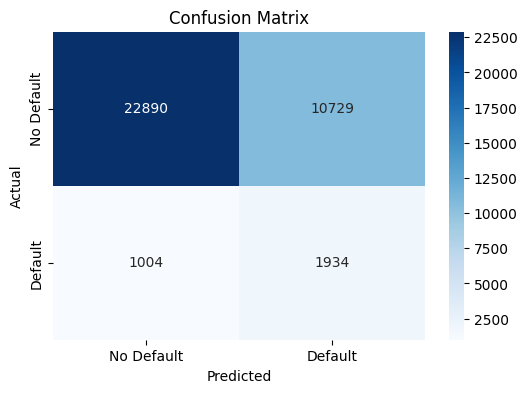

In [70]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test_recall)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [71]:


results.append({
        'Model': 'CATBoost_modified_recall',
        'Accuracy': accuracy_score(y_test, y_pred_test_recall),
        'Precision': precision_score(y_test, y_pred_test_recall),
        'Recall': recall_score(y_test, y_pred_test_recall),
        'F1 Score': f1_score(y_test, y_pred_test_recall),
        'ROC AUC': roc_auc_score(y_test, y_pred_test_recall),
        'Beta_value': 0
    })

In [72]:
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Beta_value
0,random_search_XGBoost_modified1,0.690155,0.157452,0.656229,0.253968,0.674674,4
1,random_search_CATBoost_modified,0.690155,0.157452,0.656229,0.253968,0.674674,5
3,CATBoost_modified_recall,0.679049,0.152728,0.658271,0.247933,0.669568,0
2,CATBoost_modified_micro_recall,0.875181,0.284426,0.364874,0.319666,0.642326,0


In [115]:
from catboost import CatBoostClassifier


# Define the CatBoostClassifier
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    auto_class_weights='Balanced'  # Automatically handles class imbalance
)

# Define the hyperparameter distributions
param_distributions = {
    'depth': [4],
    'learning_rate': [ 0.03],
    'iterations': [300],
    'l2_leaf_reg': [5],
    'bagging_temperature': [1.0],
    'border_count': [32]
}
#{'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 
 #'depth': 4, 'border_count': 32, 'bagging_temperature': 0.5}
# param_distributions = {
#     'depth': [4],
#     'learning_rate': [0.1],
#     'iterations': [ 200],
#     'l2_leaf_reg': [3],
#     'bagging_temperature': [0.5],
#     'border_count': [32]
# }

# Randomized search
random_search1 = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    scoring='recall',  # or 'f1_weighted'
    cv=5,
    n_iter=50,              # Try 20 random combinations
    n_jobs=1,
    verbose=3,
    random_state=42
)

# Fit to training data
random_search1.fit(X_train_prepared, y_train)

# Output best results
print("Best Parameters:", random_search1.best_params_)
print("Best Score:", random_search1.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END bagging_temperature=1.0, border_count=32, depth=4, iterations=300, l2_leaf_reg=5, learning_rate=0.03;, score=0.666 total time=   7.3s
[CV 2/5] END bagging_temperature=1.0, border_count=32, depth=4, iterations=300, l2_leaf_reg=5, learning_rate=0.03;, score=0.663 total time=   6.6s
[CV 3/5] END bagging_temperature=1.0, border_count=32, depth=4, iterations=300, l2_leaf_reg=5, learning_rate=0.03;, score=0.653 total time=   6.5s
[CV 4/5] END bagging_temperature=1.0, border_count=32, depth=4, iterations=300, l2_leaf_reg=5, learning_rate=0.03;, score=0.657 total time=   7.7s
[CV 5/5] END bagging_temperature=1.0, border_count=32, depth=4, iterations=300, l2_leaf_reg=5, learning_rate=0.03;, score=0.654 total time=   6.6s
Best Parameters: {'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 4, 'border_count': 32, 'bagging_temperature': 1.0}
Best Score: 0.6584634763080928


In [ ]:
import pickle
pickle.dump(random_search1, open('catboost_model_version_2.pkl', 'wb'))


In [117]:
# load the model from file
loaded_model = pickle.load(open('catboost_model_version_2.pkl', 'rb'))

In [125]:
loaded_model.predict(preprocessor.transform(X_train)[0].reshape(1, -1))

array([0])

In [134]:
print(X_train.shape)

(85299, 29)


In [133]:
first_row_dict = X_train.iloc[0].to_dict()
print(first_row_dict)

{'Client_Income_category': 'income_band4', 'Credit_Amount_category': 'credit_band3', 'Credit_to_Income_Category': 'Upto_2_times', 'Loan_Annuity_category': 'upto_4_percent', 'Client_Family_Members_Category': 'upto_1_member', 'Car_Owned': 1, 'Bike_Owned': 0, 'Active_Loan': 1, 'Accompany_Client': 'Relative', 'Client_Income_Type': 'Service', 'Client_Education': 'Secondary', 'Client_Marital_Status': 'S', 'Loan_Contract_Type': 'CL', 'Client_Housing_Type': 'Home', 'Registration_Years_Category': 'upto_30_years', 'ID_Years_Category': 'upto_10_years', 'Employed_Days_Category': 'upto_5_years', 'Age_Days_Category': 'upto_30_years', 'House_Own': 1.0, 'Client_Occupation': 'Laborers', 'Cleint_City_Rating': 2.0, 'Application_Process_Day': 2.0, 'Application_Hour_Category': 'upto_12_hours', 'Type_Organization_Grouped': 'Business', 'Score_Source_2': 0.728828041, 'Score_Source_3': 0.466864006, 'Social_Circle_Default': 1, 'Phone_Change_category': 'one_year', 'Credit_Bureau_Category': 'two_search'}


In [122]:
sample = preprocessor.transform(X_train[0:1])
print(sample.shape)

(1, 152)


In [73]:
# Choosing CatBoost model with optimized parameters 
# {'learning_rate': 0.03, 'l2_leaf_reg': 5, 
# 'iterations': 300, 'depth': 4, 'border_count': 32, 'bagging_temperature': 1.0}
# Optimization metric is recall  
# Best Score achieved during training : 0.6584634763080928 i.e 65.85%
# Final Model Evaluation on Test Data and the score  is 0.6582716049382716 i.e 65.83% 
# Model is properly trained without overfitting and is ready for deployment.


# Save the model
import joblib
joblib.dump(random_search1.best_estimator_, 'catboost_model_version_1.pkl')
# Load the model
loaded_model = joblib.load('catboost_model_version_1.pkl')
# Predict using the loaded model
y_pred_loaded = loaded_model.predict(X_test_prepared)
# Evaluate the loaded model
print("Loaded Model Test Recall Score:", recall_score(y_test, y_pred_loaded))
print("Loaded Model Test Accuracy Score:", accuracy_score(y_test, y_pred_loaded))
print("Loaded Model Test F1 Score:", f1_score(y_test, y_pred_loaded))
print("Loaded Model Test ROC AUC Score:", roc_auc_score(y_test, y_pred_loaded))
print("Loaded Model Test Precision Score:", precision_score(y_test, y_pred_loaded))
print("Loaded Model Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred_loaded))


Loaded Model Test Recall Score: 0.6582709326072158
Loaded Model Test Accuracy Score: 0.6790491561123725
Loaded Model Test F1 Score: 0.24793282481892187
Loaded Model Test ROC AUC Score: 0.6695679598340522
Loaded Model Test Precision Score: 0.1527284213851378
Loaded Model Test Confusion Matrix:
 [[22890 10729]
 [ 1004  1934]]


In [78]:
df1 = df.copy()

In [103]:
sample = preprocessor.transform(X_train)[0:1]
print(sample.shape)

(1, 29)


In [101]:
preprocessor.transform(X_test)[0].shape

(29,)